In [2]:
import pandas as pd
from pathlib import Path
import yfinance as yf
import numpy as np
import csv
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

In [3]:
df_50 = pd.read_csv(
    Path("./Data/QM_50_2019-12-2020-06.csv")
)

In [4]:
tickers = list(df_50["Tickers"])
len(tickers)

50

In [5]:
weighting = 1/50

In [9]:
train_start = "2019-12"
train_end = "2020-06"

In [10]:
test_start = "2020-08"
test_end = "2020-10"

In [11]:
spy = np.array(yf.Ticker("spy").history(period="2y").loc[test_start:test_end]["Close"].pct_change().cumsum().apply(np.exp))

# Lagged Price Machine Learning Model

In [13]:
lags = 5

strat = np.zeros(64)

actual = np.zeros(64)

for ticker in tickers:
    # Pull the historical data
    df_price = yf.Ticker(ticker).history(period="max")
    df_price["return"] = df_price["Close"].pct_change()
    
    # Create lags price
    cols = []
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        df_price[col] = df_price['Close'].shift(lag)
        cols.append(col)
        
    df_price.dropna(inplace=True)
    
    # Create train and test data
    df_price_train = df_price.loc[:train_end]
    
    df_price_test = df_price.loc[test_start:test_end]
    
    model = LogisticRegression(C=1e-2, solver="lbfgs",
                              multi_class="auto",
                              max_iter=1000)
    
    model.fit(df_price_train[cols], np.sign(df_price_train["return"]))
    
    df_price_test["prediction"] = model.predict(df_price_test[cols])
    
    df_price_test["strategy"] = df_price_test["prediction"] * df_price_test["return"]
    
    cum_ret = df_price_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

PAYC
CLX
CDNS
SNPS
ADSK
TMUS
ILMN
MNST
MSFT
ADBE
CARR
CTLT
MCO
IDXX
BLK
PENN
NEM
AMZN
EFX
FB
NVDA
EBAY
KLAC
RMD
DHR
TSLA
SPGI
AAPL
CCI
ODFL
VRSK
CMG
DXCM
POOL
TTWO
ROL
LRCX
ENPH
EQIX
ETSY
CRM
BIO
WST
MPWR
ABBV
NOW
IPGP
KR
ANSS
TER


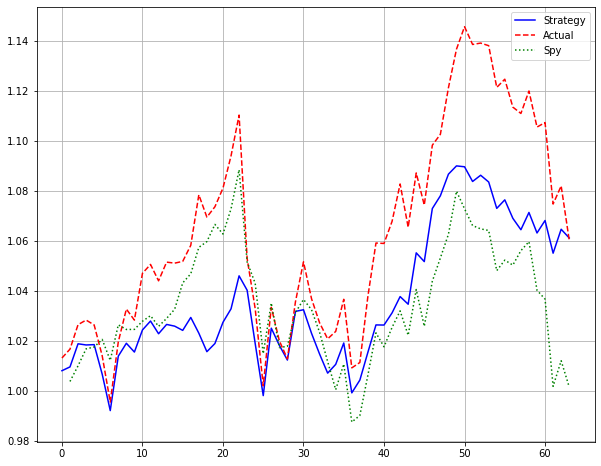

In [14]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# SMA Machine Learning Model

In [17]:
%%time
short_win = 5
long_win = 15

weighting = 1/50

strat = np.zeros(64)

actual = np.zeros(64)

for ticker in tickers:
    
    historical = yf.Ticker(ticker).history(period="max")
    historical["return"] = historical["Close"].pct_change()
    historical["SMA_short"] = historical["Close"].rolling(window=short_win).mean().shift()
    historical["SMA_long"] = historical["Close"].rolling(window=long_win).mean().shift()
    historical["distance1"] = (historical["Close"] - historical["SMA_short"]).shift()
    historical["distance2"] = (historical["SMA_short"] - historical["SMA_long"]).shift()
    historical["distance3"] = (historical["Close"] - historical["SMA_long"]).shift()
    
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[train_start:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    X_train_scaled = X_scaler.transform(historical_train[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    X_test_scaled = X_scaler.transform(historical_test[["SMA_short","SMA_long","distance1","distance2","distance3"]])
    
    svm_model = SVC()
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

PAYC
CLX
CDNS
SNPS
ADSK
TMUS
ILMN
MNST
MSFT
ADBE
CARR
CTLT
MCO
IDXX
BLK
PENN
NEM
AMZN
EFX
FB
NVDA
EBAY
KLAC
RMD
DHR
TSLA
SPGI
AAPL
CCI
ODFL
VRSK
CMG
DXCM
POOL
TTWO
ROL
LRCX
ENPH
EQIX
ETSY
CRM
BIO
WST
MPWR
ABBV
NOW
IPGP
KR
ANSS
TER
CPU times: user 5.97 s, sys: 355 ms, total: 6.33 s
Wall time: 25.6 s


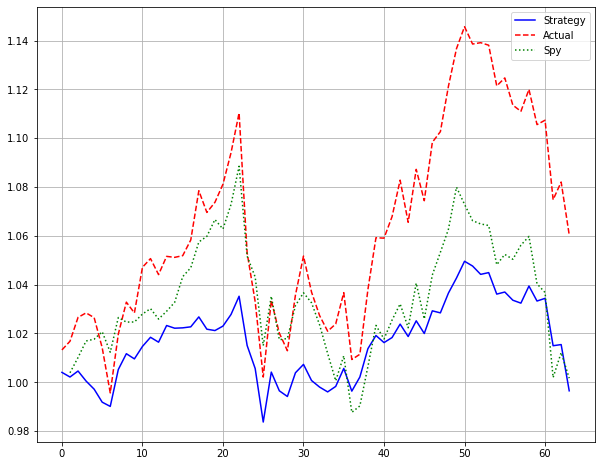

In [18]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# EMA Machine Learning Model

In [20]:
short_win = 12
long_win = 26

strat = np.zeros(64)

actual = np.zeros(64)

for ticker in tickers:
    historical = yf.Ticker(ticker).history(period="2y")
    historical["return"] = historical["Close"].pct_change()
    historical["exp1"] = historical["Close"].ewm(span=short_win, adjust=False).mean().shift()
    historical["exp2"] = historical["Close"].ewm(span=long_win, adjust=False).mean().shift()
    historical["distance1"] = (historical["Close"] - historical["exp1"]).shift()
    historical["distance2"] = (historical["Close"] - historical["exp2"]).shift()
    historical["distance3"] = (historical["exp1"] - historical["exp2"]).shift()
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[train_start:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["exp1","exp2","distance1","distance2","distance3"]])
    X_train_scaled = X_scaler.transform(historical_train[["exp1","exp2","distance1","distance2","distance3"]])
    X_test_scaled = X_scaler.transform(historical_test[["exp1","exp2","distance1","distance2","distance3"]])
    
    svm_model = SVC(C=0.5)
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker)

PAYC
CLX
CDNS
SNPS
ADSK
TMUS
ILMN
MNST
MSFT
ADBE
CARR
CTLT
MCO
IDXX
BLK
PENN
NEM
AMZN
EFX
FB
NVDA
EBAY
KLAC
RMD
DHR
TSLA
SPGI
AAPL
CCI
ODFL
VRSK
CMG
DXCM
POOL
TTWO
ROL
LRCX
ENPH
EQIX
ETSY
CRM
BIO
WST
MPWR
ABBV
NOW
IPGP
KR
ANSS
TER


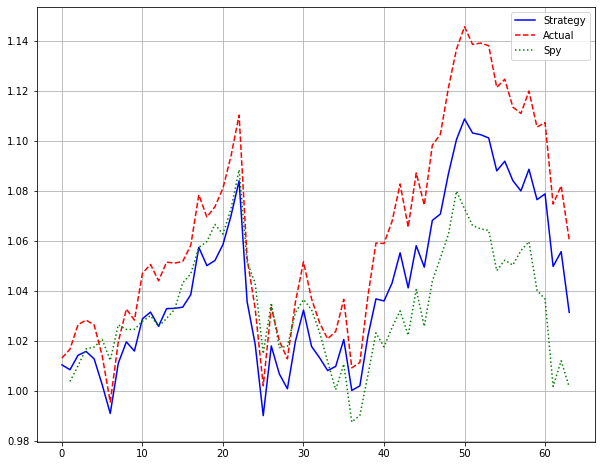

In [21]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()

# MACD Machine Learning Model

In [23]:
short_win = 12
long_win = 26
signal_line = 9
strat = np.zeros(64)

actual = np.zeros(64)

for ticker in tickers:
    historical = yf.Ticker(ticker).history(period="2y")
    historical["return"] = historical["Close"].pct_change()
    historical["exp1"] = historical["Close"].ewm(span=short_win, adjust=False).mean().shift()
    historical["exp2"] = historical["Close"].ewm(span=long_win, adjust=False).mean().shift()
    historical["macd"] = historical["exp1"] - historical["exp2"]
    historical["exp3"] = historical["Close"].ewm(span=signal_line, adjust=False).mean().shift()
    historical["macd_histogram"] = historical["macd"] - historical["exp3"]
    historical["lag_1"] = historical["Close"].shift()
    historical["roc"] = ((historical["Close"] - historical["lag_1"])/ historical["lag_1"]).shift()
    historical["macd_histogram_lag1"] = historical["macd_histogram"].shift()
    historical["roc_macd"] = ((historical["macd_histogram"]-historical["macd_histogram_lag1"])/historical["macd_histogram_lag1"])
    historical.dropna(inplace=True)
    
    historical_train = historical.loc[:train_end].copy()
    historical_test = historical.loc[test_start:test_end].copy()
    
    scaler = StandardScaler()
    X_scaler = scaler.fit(historical_train[["roc","roc_macd"]])
    X_train_scaled = X_scaler.transform(historical_train[["roc","roc_macd"]])
    X_test_scaled = X_scaler.transform(historical_test[["roc","roc_macd"]])
    
    svm_model = SVC(C=0.5)
    svm_model = svm_model.fit(X_train_scaled, np.sign(historical_train[["return"]]))
    
    historical_test["prediction"] = svm_model.predict(X_test_scaled)
    
    historical_test["strategy"] = historical_test["prediction"] * historical_test["return"]
    
    cum_ret = historical_test[["strategy","return"]].cumsum().apply(np.exp)
    
    strat = strat + np.array(cum_ret["strategy"]) * weighting
    
    actual = actual + np.array(cum_ret["return"]) * weighting
    
    print(ticker, accuracy_score(historical_test["prediction"],
                                np.sign(historical_test["return"])))

PAYC 0.59375
CLX 0.4375
CDNS 0.53125
SNPS 0.53125
ADSK 0.546875
TMUS 0.546875
ILMN 0.5
MNST 0.484375
MSFT 0.59375
ADBE 0.53125
CARR 0.65625
CTLT 0.453125
MCO 0.546875
IDXX 0.59375
BLK 0.59375
PENN 0.5
NEM 0.390625
AMZN 0.546875
EFX 0.484375
FB 0.5
NVDA 0.46875
EBAY 0.453125
KLAC 0.546875
RMD 0.53125
DHR 0.484375
TSLA 0.59375
SPGI 0.484375
AAPL 0.53125
CCI 0.515625
ODFL 0.609375
VRSK 0.484375
CMG 0.5
DXCM 0.4375
POOL 0.453125
TTWO 0.5625
ROL 0.515625
LRCX 0.421875
ENPH 0.625
EQIX 0.453125
ETSY 0.53125
CRM 0.5625
BIO 0.625
WST 0.5
MPWR 0.546875
ABBV 0.4375
NOW 0.5
IPGP 0.5625
KR 0.578125
ANSS 0.59375
TER 0.546875


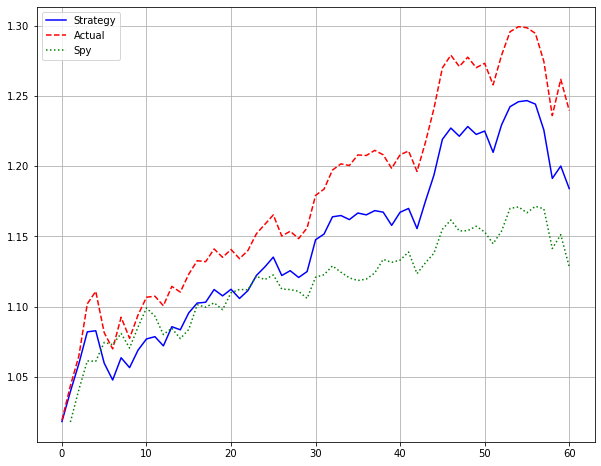

In [24]:
plt.figure(figsize=(10,8))
plt.plot(strat,'b-', label="Strategy")
plt.plot(actual,'r--', label="Actual")
plt.plot(spy,'g:', label="Spy")
plt.grid()
plt.legend()